# FAST EXACT TOMOGRAPHIC PROJECTION WITH BASIS FUNCTIONS

This notebook documents the implementation of a novel approach to tomography using spline basis functions instead of pixels. The goal is to compute the x-ray transform in an exact and efficient manner. The technique presented here offers a fast and accurate alternative to traditional pixel-based tomographic methods. This notebook serves as a comprehensive guide to understanding and implementing the proposed approach.


In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

This code supports efficient GPU computation. The computation of the X-ray operator takes advantage of a fine-grained parallelism implementation via ray-tracing.


In [2]:
cp.cuda.Device(0).use()

<CUDA Device 0>

Definition of the geometry of the problem

(510, 510)


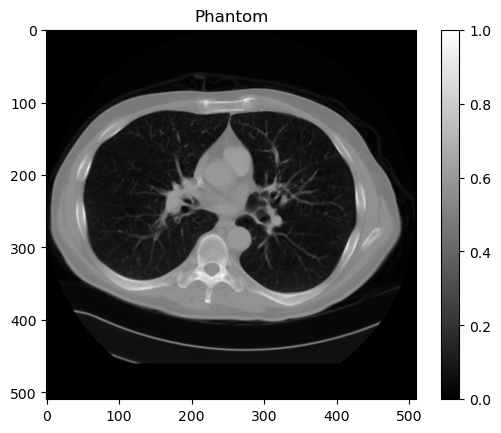

In [3]:
from skimage import io
import scipy
# Specify the path to your TIFF image file
image_path = "true.tiff"
# Open the TIFF image
phantom = io.imread(image_path)
phantom = (phantom - np.min(phantom))/(np.max(phantom) - np.min(phantom))
phantom = phantom[50:, :]
phantom = np.concatenate((phantom, np.zeros((50, phantom.shape[1]))), axis=0)
phantom = phantom[1:-1, 1:-1]
circle_mask_zeros = np.meshgrid(*[np.linspace(-1, 1, phantom.shape[i]) for i in range(2)], indexing='ij')
circle_mask = np.sqrt(circle_mask_zeros[0]**2 + circle_mask_zeros[1]**2) < 1
phantom = phantom * circle_mask
print(phantom.shape)

pitch = 1.  # m/px [can differ per axis]

plt.figure('Phantom')
plt.imshow(phantom, cmap='gray')
plt.title('Phantom')
plt.colorbar()
plt.show()

In [4]:
N_angle  = 500 #30 20 old
N_offset = 400 #400
new_sampling = phantom.shape[0] #phantom.shape[0]
N_side = phantom.shape[0]
arg_shape = phantom.shape

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)
t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

### Definition of the operators 
> X-ray transform with splines-basis functions of degree 0 (pixels), 1, or 2.

\begin{equation}
    \mathcal{P}_{\theta}\{f\}(z) = \int_{\mathbb{R}} f(t \theta+{P}_{\theta^{\perp}}^{T}z)\ \mathrm{d} t,
\end{equation}

In [5]:
op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

In [6]:
stop_crit = pxst.MaxIter(30)

/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/cryoem/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


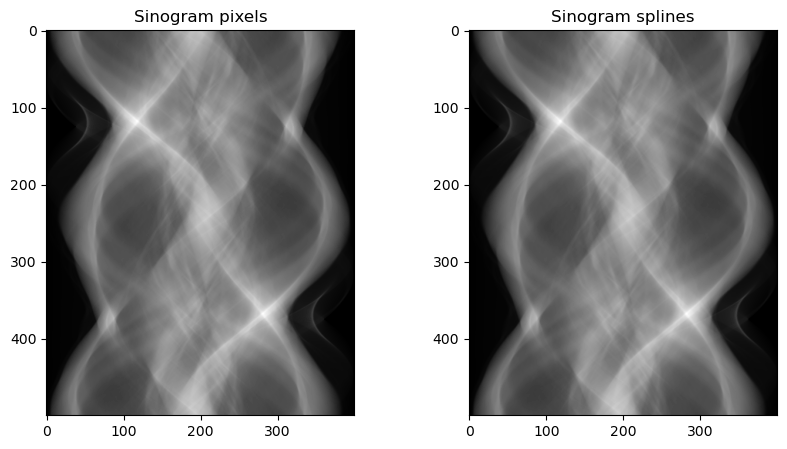

In [7]:
# same with pixels
fwd_pixels = op_pixels.apply(phantom.reshape(-1))
fwd_pixels = (fwd_pixels - cp.min(fwd_pixels))/(cp.max(fwd_pixels) - cp.min(fwd_pixels))
# adding noise
#fwd_pixels += 0.004*cp.random.randn(*fwd_pixels.shape)

# bakcprojection
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_splines_2 = (fwd_splines_2 - cp.min(fwd_splines_2))/(cp.max(fwd_splines_2) - cp.min(fwd_splines_2))
# adding noise
#fwd_splines_2 += 0.004*cp.random.randn(*fwd_splines_2.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fwd_pixels.get().reshape(N_angle, N_offset), cmap='gray')
axs[0].set_title('Sinogram pixels')
axs[1].imshow(fwd_splines_2.get().reshape(N_angle, N_offset), cmap='gray')
axs[1].set_title('Sinogram splines')
plt.show()


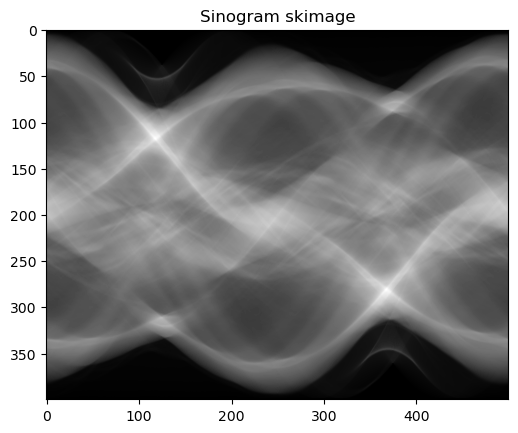

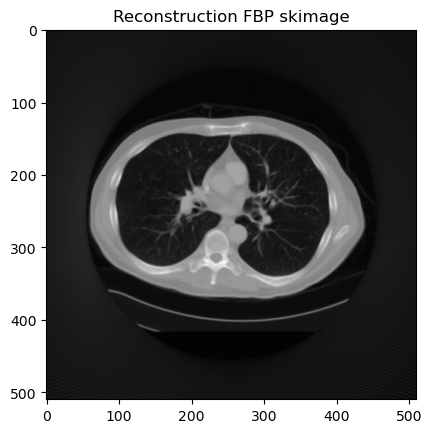

PSNR skimage: 13.551760538960531


In [8]:
from skimage.transform import iradon, radon
from skimage.metrics import peak_signal_noise_ratio as psnr
# ssim
from skimage.metrics import structural_similarity as ssim

#y_data_skimage = radon(phantom.get(), theta=angles*180/np.pi, circle=False)
#print(y_data_skimage.shape)
#y_data_skimage = (y_data_skimage - np.min(y_data_skimage))/(np.max(y_data_skimage) - np.min(y_data_skimage))
#y_data_skimage += 0.004*np.random.randn(*y_data_skimage.shape)

y_data_skimage = fwd_pixels.get().reshape(N_angle, N_offset).T
plt.figure('sino')
plt.imshow(y_data_skimage, cmap='gray')
plt.title('Sinogram skimage')
plt.show()

recon_fbp_skimage = iradon(y_data_skimage, theta=angles*180/np.pi, circle=False, output_size=new_sampling)
plt.figure('recon fbp skimage')
plt.imshow(recon_fbp_skimage, cmap='gray')
plt.title('Reconstruction FBP skimage')
plt.show()

recon_fbp_skimage = (recon_fbp_skimage - np.min(recon_fbp_skimage))/(np.max(recon_fbp_skimage) - np.min(recon_fbp_skimage))

comp_fbp_skimage = recon_fbp_skimage[150:350, 150:350]
comp_fbp_skimage = (comp_fbp_skimage - np.min(comp_fbp_skimage))/(np.max(comp_fbp_skimage) - np.min(comp_fbp_skimage))
comp_phantom = phantom.get()[150:350, 150:350]
comp_phantom = (comp_phantom - np.min(comp_phantom))/(np.max(comp_phantom) - np.min(comp_phantom))
print('PSNR skimage:', psnr(comp_phantom, comp_fbp_skimage))


In [9]:
# now we reconstruct in a smaller domain (size N_offset, N_offset)
N_offset = new_sampling
arg_shape = (N_offset, N_offset)
pitch = (phantom.shape[0] / N_offset, phantom.shape[1] / N_offset)
op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


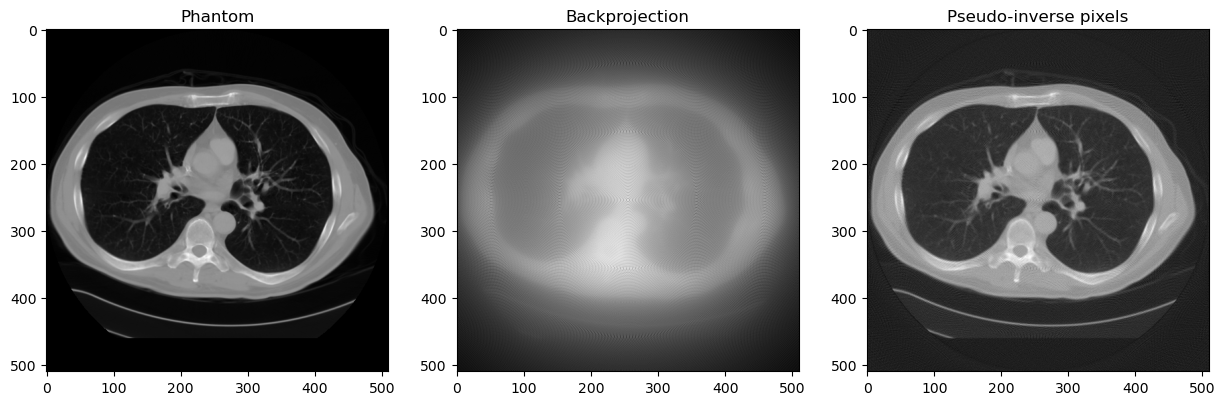

PSNR pinv pixels: 26.10359739149338


In [10]:
# performing backprojection
backprojection_pixels = op_pixels.adjoint(fwd_pixels)

# performing pseudo-inverse via CGD
pinv_pixels = op_pixels.pinv(fwd_pixels, damp=0.001, kwargs_fit=dict(stop_crit=stop_crit)).reshape(arg_shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(phantom.get(), cmap='gray')
ax[0].set_title('Phantom')
ax[1].imshow(backprojection_pixels.get().reshape(arg_shape), cmap='gray')
ax[1].set_title('Backprojection')
ax[2].imshow(pinv_pixels.get(), cmap='gray')
ax[2].set_title('Pseudo-inverse pixels')
plt.show()

comp_pix = pinv_pixels.get()[150:350, 150:350]
comp_pix = (comp_pix - np.min(comp_pix))/(np.max(comp_pix) - np.min(comp_pix))
comp_phantom = phantom.get()[150:350, 150:350]
comp_phantom = (comp_phantom - np.min(comp_phantom))/(np.max(comp_phantom) - np.min(comp_phantom))
if comp_pix.shape[0] == comp_phantom.shape[0]:
    print('PSNR pinv pixels:', psnr(comp_phantom, comp_pix))


In [11]:
# performing backprojection
backprojection_splines_2 = op_splines_2.adjoint(fwd_splines_2)

# performing pseudo-inverse via CGD
pinv_splines_2 = op_splines_2.pinv(fwd_splines_2, damp=0.001, kwargs_fit=dict(stop_crit=stop_crit)).reshape(arg_shape)

/home/haouchat/cryoem/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


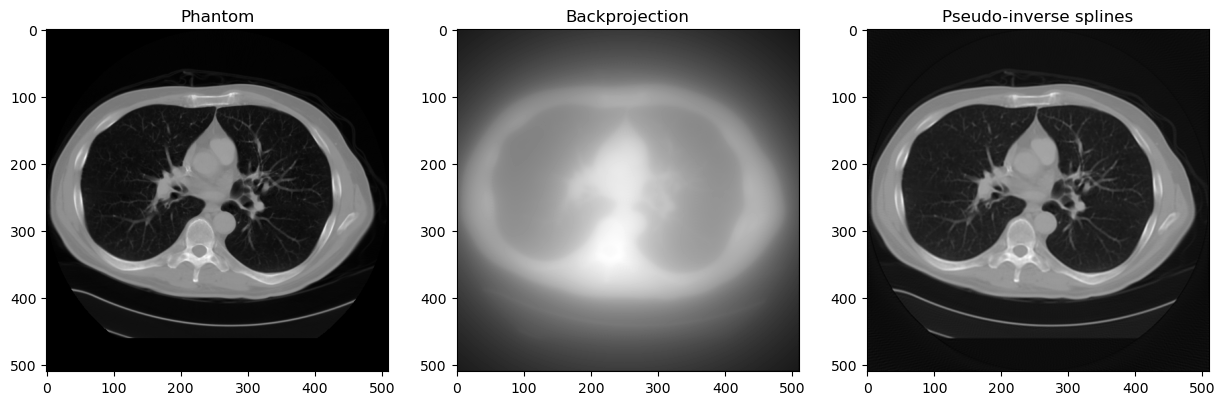

PSNR pinv splines 2: 42.10271548451737


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(phantom.get(), cmap='gray')
ax[0].set_title('Phantom')
ax[1].imshow(backprojection_splines_2.get().reshape(arg_shape), cmap='gray')
ax[1].set_title('Backprojection')
ax[2].imshow(pinv_splines_2.get(), cmap='gray')
ax[2].set_title('Pseudo-inverse splines')
plt.show()

comp_spl = pinv_splines_2.get()[150:350, 150:350]
comp_spl = (comp_spl - np.min(comp_spl))/(np.max(comp_spl) - np.min(comp_spl))
comp_phantom = phantom.get()[150:350, 150:350]
comp_phantom = (comp_phantom - np.min(comp_phantom))/(np.max(comp_phantom) - np.min(comp_phantom))

if comp_spl.shape[0] == comp_phantom.shape[0]:
    print('PSNR pinv splines 2:', psnr(comp_phantom, comp_spl))


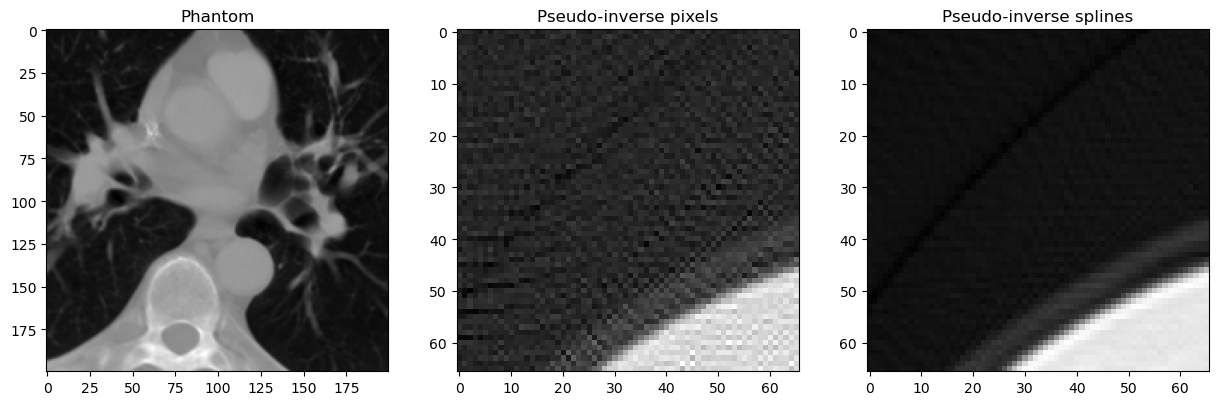

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5)) #imshow zoomed in
comp_pix = pinv_pixels.get()[150//3:350//3, 150//3:350//3]
comp_spl = pinv_splines_2.get()[150//3:350//3, 150//3:350//3]
ax[0].imshow(comp_phantom, cmap='gray')
ax[0].set_title('Phantom')
ax[1].imshow(comp_pix, cmap='gray')
ax[1].set_title('Pseudo-inverse pixels')
ax[2].imshow(comp_spl, cmap='gray')
ax[2].set_title('Pseudo-inverse splines')
plt.show()

3


(510, 510) (510, 510)
PSNR pinv pixels: 26.10359739149338
PSNR pinv splines 2: 42.10271548451737


Text(0.5, 1.0, 'Pseudo-inverse splines')

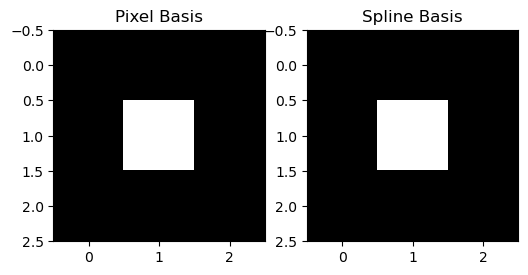

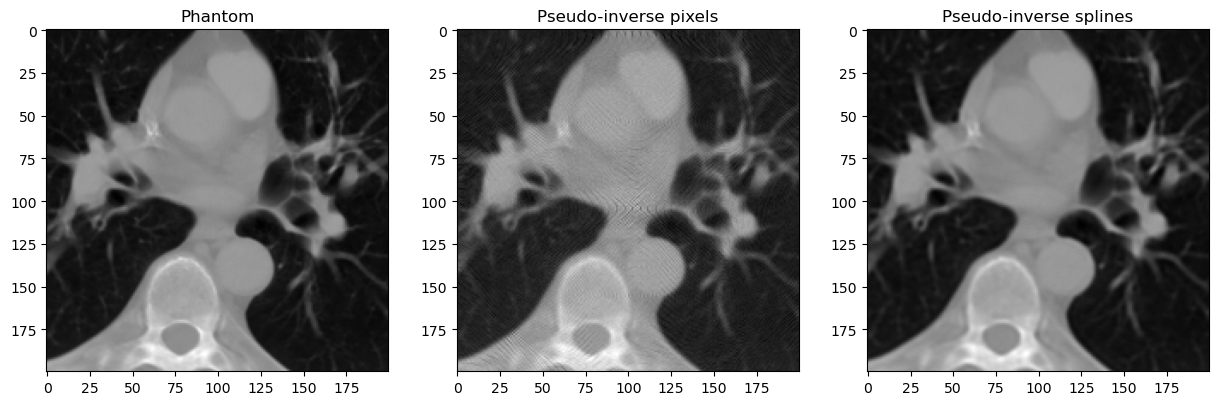

In [14]:
#upsampling
from scipy.signal import convolve2d as spconv

rec_pix = pinv_pixels.get()
rec_spline = pinv_splines_2.get()

nn = 3*phantom.shape[0]//new_sampling
print(nn)
mini_im = np.zeros((nn,nn))
nn1, nn2 = nn//3, 2*nn//3
mini_im_pix = mini_im
mini_im_spline = mini_im

mini_im_pix[nn1:nn2, nn1:nn2] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[nn1:nn2, nn1:nn2], mode='same')
mini_im_spline = spconv(mini_im_spline, mini_im_pix[nn1:nn2, nn1:nn2], mode='same')

ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

full_im_pix = np.zeros((N_offset*nn1 + nn2, N_offset*nn1 + nn2))
for i in range(N_offset):
    for j in range(N_offset):
        i_min, i_max, j_min, j_max = nn1*i, nn1*i+nn, nn1*j, nn1*j+nn
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * rec_pix[i,j]

full_im_spline = np.zeros((N_offset*nn1 + nn2, N_offset*nn1 + nn2))
for i in range(N_offset):
    for j in range(N_offset):
        i_min, i_max, j_min, j_max = nn1*i, nn1*i+nn, nn1*j, nn1*j+nn
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * rec_spline[i,j]

full_im_pix = full_im_pix[nn2//2:-nn2//2, nn2//2:-nn2//2]
full_im_spline = full_im_spline[nn2//2:-nn2//2, nn2//2:-nn2//2]
print(full_im_pix.shape, full_im_spline.shape)  

comp_pix = full_im_pix[150:350, 150:350]
comp_spl = full_im_spline[150:350, 150:350]
comp_pix = (comp_pix - np.min(comp_pix))/(np.max(comp_pix) - np.min(comp_pix))
comp_spl = (comp_spl - np.min(comp_spl))/(np.max(comp_spl) - np.min(comp_spl))
comp_phantom = phantom.get()[150:350, 150:350]
comp_phantom = (comp_phantom - np.min(comp_phantom))/(np.max(comp_phantom) - np.min(comp_phantom))

if comp_pix.shape[0] == comp_phantom.shape[0]:
    print('PSNR pinv pixels:', psnr(comp_phantom, comp_pix))
if comp_spl.shape[0] == comp_phantom.shape[0]:
    print('PSNR pinv splines 2:', psnr(comp_phantom, comp_spl))

fig, ax = plt.subplots(1, 3, figsize=(15, 5)) #imshow zoomed in
ax[0].imshow(comp_phantom, cmap='gray')
ax[0].set_title('Phantom')
ax[1].imshow(comp_pix, cmap='gray')
ax[1].set_title('Pseudo-inverse pixels')
ax[2].imshow(comp_spl, cmap='gray')
ax[2].set_title('Pseudo-inverse splines')

/tmp/ipykernel_3678490/2618307388.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[0].imshow(full_im_pix[150:350, 150:350], cmap='gray')
/tmp/ipykernel_3678490/2618307388.py:4: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0].imshow(full_im_pix[150:350, 150:350], cmap='gray')
/tmp/ipykernel_3678490/2618307388.py:8: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[2].imshow(full_im_spline[150:350, 150:350], cmap='gray')
/tmp/ipykernel_3678490/2618307388.py:8: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[2].imshow(full_im_spline[150:350, 150:350], cmap='gray')


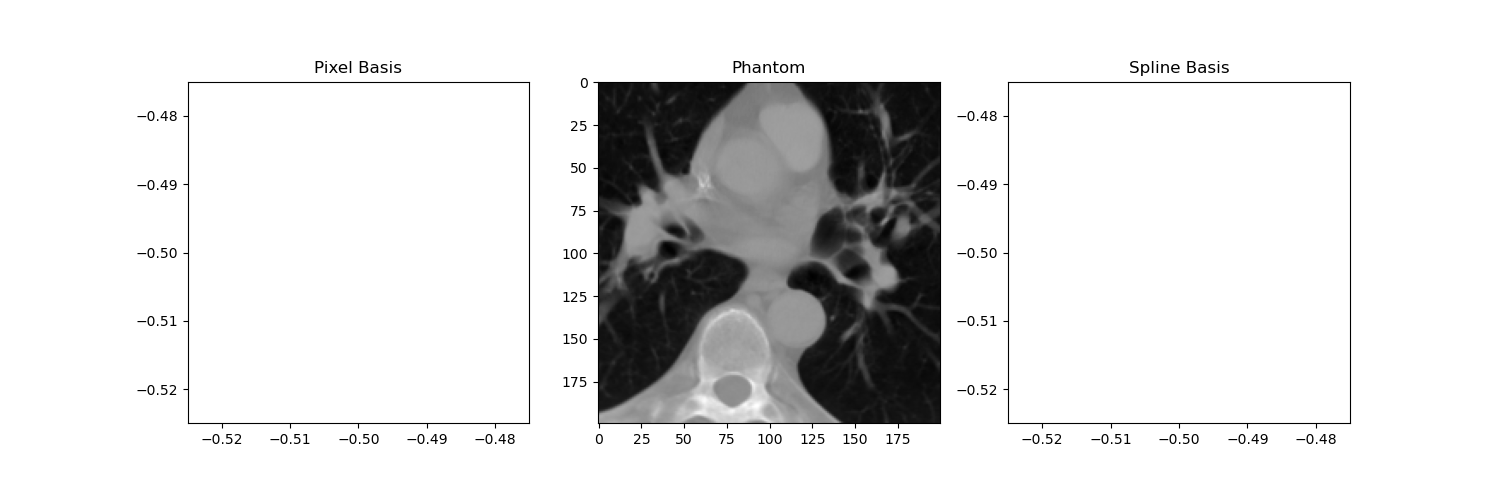

(50, 50) (50, 50) (510, 510)


ValueError: zero-size array to reduction operation minimum which has no identity

In [17]:
#interactive matplotlib 
%matplotlib widget
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(full_im_pix[150:350, 150:350], cmap='gray')
ax[0].set_title('Pixel Basis')
ax[1].imshow(comp_phantom, cmap='gray')
ax[1].set_title('Phantom')
ax[2].imshow(full_im_spline[150:350, 150:350], cmap='gray')
ax[2].set_title('Spline Basis')
plt.show()
print(full_im_pix.shape, full_im_spline.shape, phantom.get().shape)

full_im_pix = full_im_pix[150:350, 150:350]
full_im_spline = full_im_spline[150:350, 150:350]
comp_pix = (full_im_pix - np.min(full_im_pix))/(np.max(full_im_pix) - np.min(full_im_pix))
comp_spline = (full_im_spline - np.min(full_im_spline))/(np.max(full_im_spline) - np.min(full_im_spline))
print('range pix:', np.min(comp_pix), np.max(comp_pix))
print('range spline:', np.min(comp_spline), np.max(comp_spline))
print('PSNR pinv pixels:', psnr(comp_phantom, full_im_pix))
print('PSNR pinv splines 2:', psnr(comp_phantom, full_im_spline))


200 349


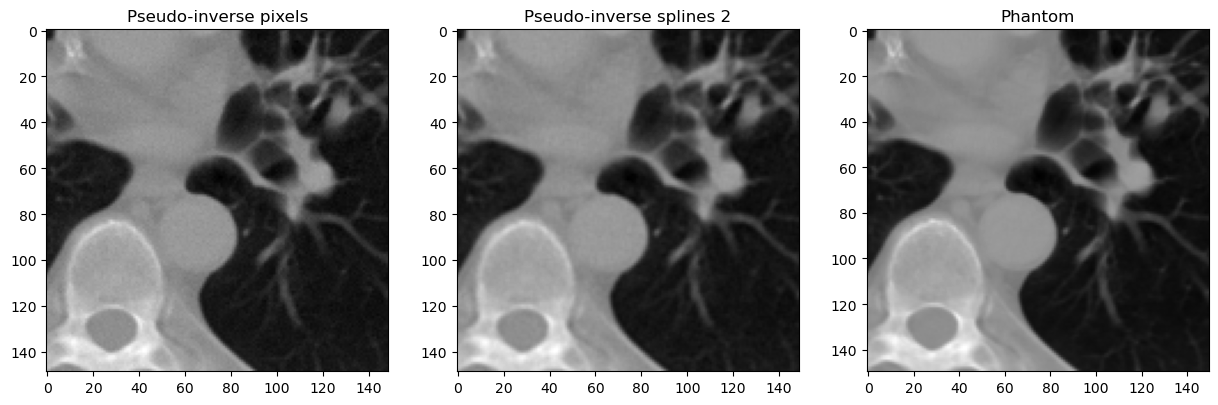

ValueError: operands could not be broadcast together with shapes (150,150) (149,149) 

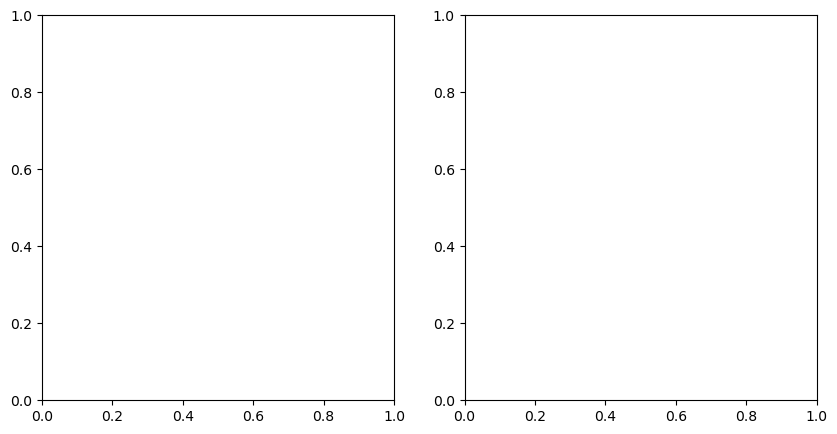

In [14]:
# compare pixel fbp with spline cgd
dim1 = 200
dim2 = 350
t1, t2 = dim1 * full_im_pix.shape[0] // phantom.shape[0], dim2 * full_im_pix.shape[0] // phantom.shape[0]-1
print(t1, t2)
comp_pix = full_im_pix[t1:t2, t1:t2]
comp_pix = (comp_pix - np.min(comp_pix))/(np.max(comp_pix) - np.min(comp_pix))
comp_spl = full_im_spline[t1:t2, t1:t2]
comp_spl = (comp_spl - np.min(comp_spl))/(np.max(comp_spl) - np.min(comp_spl))
comp_phantom = phantom.get()[dim1:dim2, dim1:dim2]
comp_phantom = (comp_phantom - np.min(comp_phantom))/(np.max(comp_phantom) - np.min(comp_phantom))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(comp_pix, cmap='gray')
ax[0].set_title('Pseudo-inverse pixels')
ax[1].imshow(comp_spl, cmap='gray')
ax[1].set_title('Pseudo-inverse splines 2')
ax[2].imshow(comp_phantom, cmap='gray')
ax[2].set_title('Phantom')
plt.show()

# imshow the differences
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im1 = ax[0].imshow(comp_phantom - comp_pix, cmap='gray')
ax[0].set_title('Phantom - Pseudo-inverse pixels')
# vmin vmax are set to the same values to compare the images
im2 = ax[1].imshow(comp_phantom - comp_spl, cmap='gray', vmin=im1.norm.vmin, vmax=im1.norm.vmax)
ax[1].set_title('Phantom - Pseudo-inverse splines 2')
plt.show()

print('PSNR pinv pixels:', psnr(comp_phantom, comp_pix))
print('PSNR pinv splines 2:', psnr(comp_phantom, comp_spl))
print('ssim pinv pixels:', ssim(comp_phantom, comp_pix))
print('ssim pinv splines 2:', ssim(comp_phantom, comp_spl))

In [6]:
pitch = 1.  # m/px [can differ per axis]
arg_shape = phantom.shape

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)


#N_angle  = 50
N_offset_true = 1000
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset_true, endpoint=True)

n_spec_true  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset_true, 2))  # (N_angle, N_offset_true, 2)
t_spec_true  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset_true, 1)  # (N_angle, N_offset_true, 2)
t_spec_true += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset_true,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec_true  = cp.array(t_spec_true)
n_spec_true  = cp.array(n_spec_true)

op_true = pxr.XRayTransform.init( #for reconstruction
    arg_shape=arg_shape,
    t_spec=t_spec_true.reshape(-1,2), 
    n_spec=n_spec_true.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels
y_data_spline2 = fwd_splines_2

# benchmarking 
'''
bench_splines_1 = benchmark(op_splines_1.apply, (phantom.reshape(-1),), n_repeat=10)
print("splines : ", bench_splines_1)
bench_pixels    = benchmark(op_pixels.apply, (phantom.reshape(-1),), n_repeat=10)
print("pixels : ", bench_pixels)
breakpoint()
'''

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

stop_crit = pxst.MaxIter(20) #30 before

oversampling = phantom.shape[0]
op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)

#add noise
y_data = (y_data - cp.min(y_data))/(cp.max(y_data) - cp.min(y_data))
y_data_spline2 = (y_data_spline2 - cp.min(y_data_spline2))/(cp.max(y_data_spline2) - cp.min(y_data_spline2))
#y_data = y_data + 0.004*cp.random.randn(*y_data.shape)

/home/haouchat/cryoem/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/cryoem/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


psnr pixels :  18.895058421368535
psnr splines :  19.311637733096116
sample normal
norm diff splines :  86058.77958088598
norm diff pixels  :  85424.18559666592
Oversampled
norm diff splines :  23196.25089821499
norm diff pixels  :  24331.75217568605


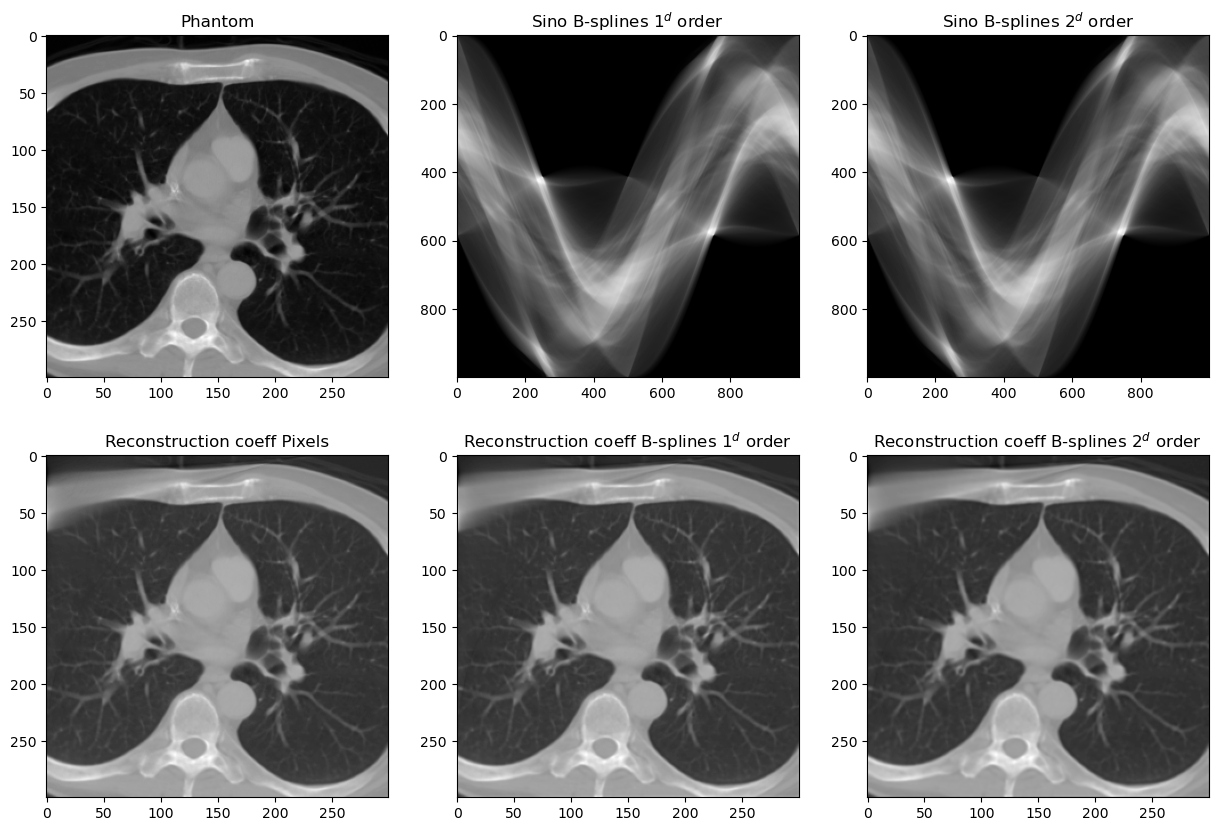

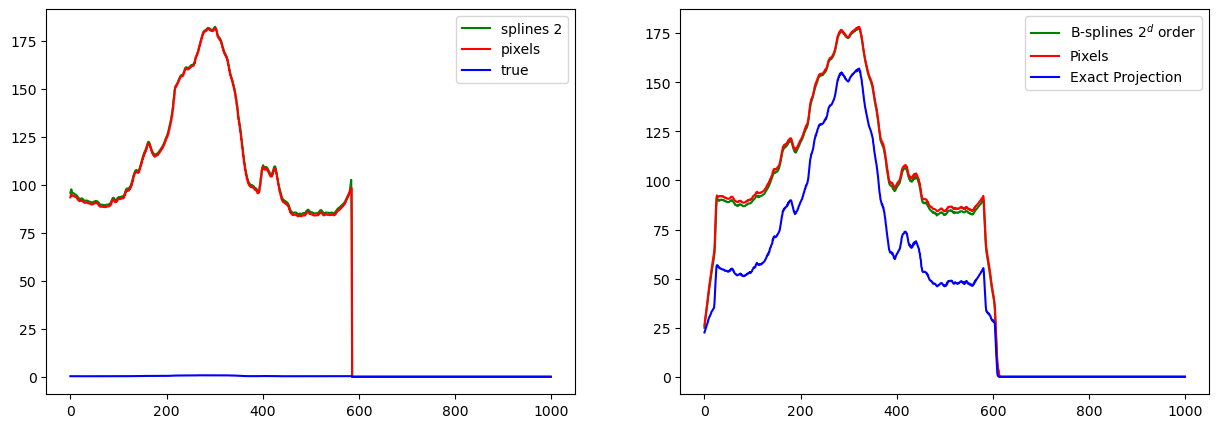

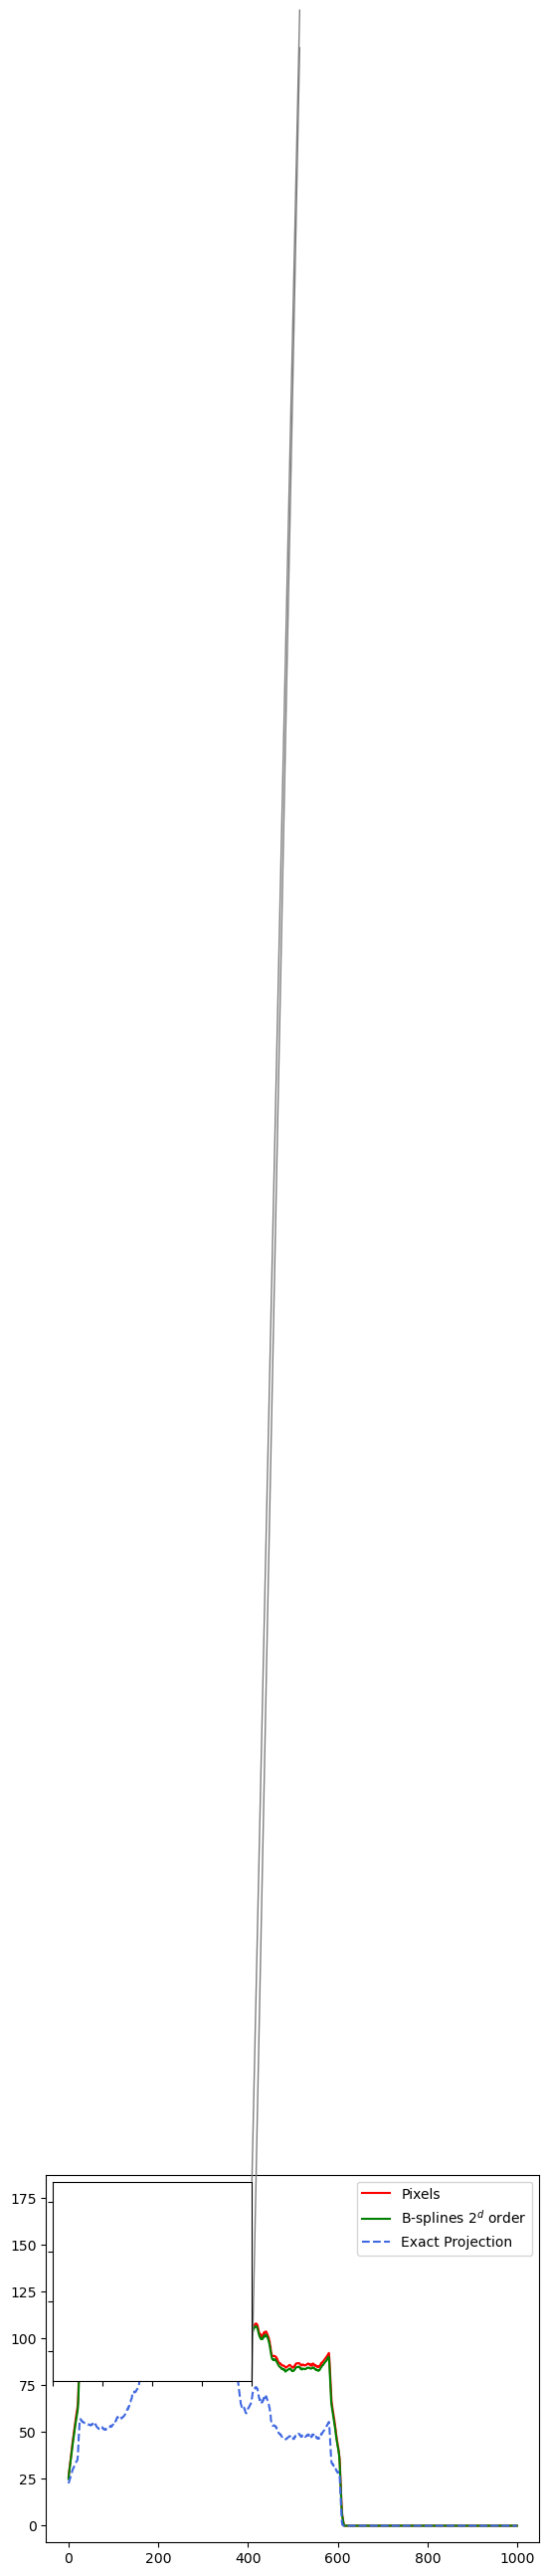

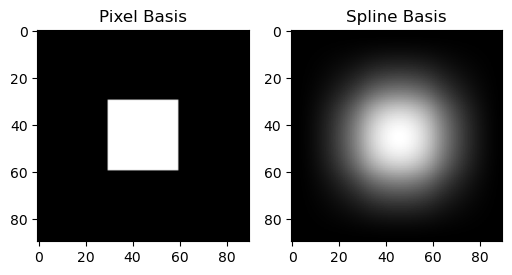

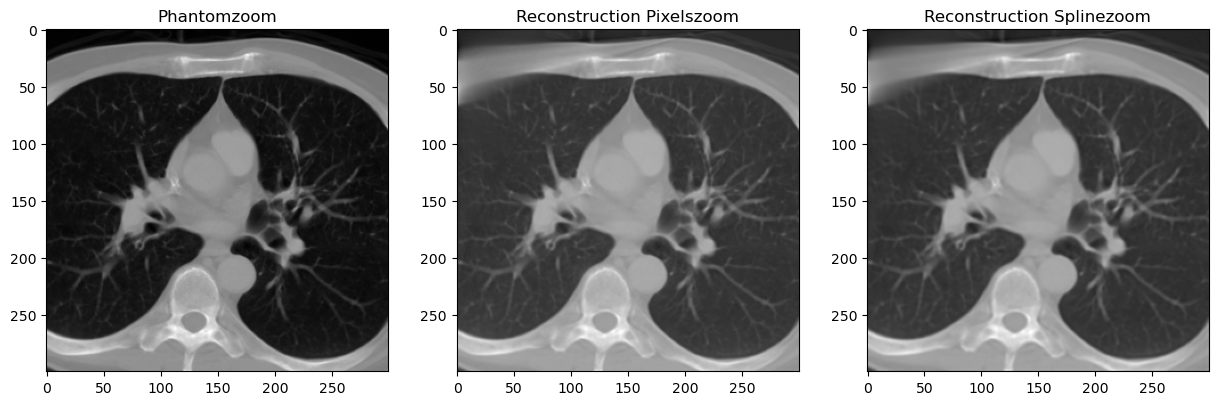

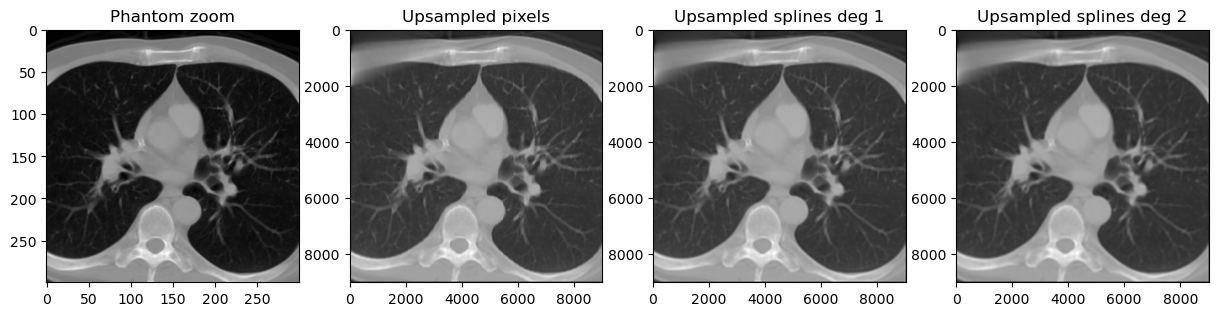

In [7]:
recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
#recon_pixels = cp.array(recon_fbp_skimage).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data_spline2, damp=0.001, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_splines_1.T, cmap='gray')
axes[0, 1].set_title('Sino B-splines $1^d$ order')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')
from skimage.metrics import peak_signal_noise_ratio as psnr
recon_pixels = (recon_pixels - cp.min(recon_pixels))/(cp.max(recon_pixels) - cp.min(recon_pixels))
recon_box_1 = (recon_box_1 - cp.min(recon_box_1))/(cp.max(recon_box_1) - cp.min(recon_box_1))
recon_box_2 = (recon_box_2 - cp.min(recon_box_2))/(cp.max(recon_box_2) - cp.min(recon_box_2))
print('psnr pixels : ', psnr(phantom.get()[100:, :], recon_pixels.get()[100:, :]))
print('psnr splines : ', psnr(phantom.get()[100:, :], recon_box_2.get()[100:, :]))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()


#N_angle  = 50
N_offset = 1000 
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

ax.plot(fwd_splines[9], label='B-splines $2^d$ order', c='green')
axins.plot(fwd_splines[9], label='B-splines $2^d$ order', c='green')

ax.plot(true_proj[9], label='Exact Projection', c='royalblue', linestyle = '--')
axins.plot(true_proj[9], label='Exact Projection', c='royalblue', linestyle = '--')


x1, x2, y1, y2 = 505-10, 505+10, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

# Upsampling to approach continuum
nn = 90
mini_im = np.zeros((nn,nn))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline = recon_box_2.get()

mini_im_pix[nn//3:2*nn//3, nn//3:2*nn//3] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#plt.figure('pix upsampling')
#plt.imshow(mini_im_pix, cmap='gray')
ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline = spconv(mini_im_pix, mini_im_pix[nn//3:2*nn//3, nn//3:2*nn//3], mode='same')/100**2
mini_im_spline = spconv(mini_im_spline, mini_im_pix[nn//3:2*nn//3, nn//3:2*nn//3], mode='same')/100**2

#plt.figure()
#plt.imshow(mini_im_spline)
ax[1].imshow(mini_im_spline, cmap='gray')
ax[1].set_title('Spline Basis')

fig, ax = plt.subplots(1, 3, figsize=(15, 5)) #plot zoomed in reconstructions : phantom, pixel, spline
ax[0].imshow(phantom.get(), cmap='gray')
recpixzoom = (rec_pix - np.min(rec_pix))/(np.max(rec_pix) - np.min(rec_pix))    
recsplinezoom = (rec_spline - np.min(rec_spline))/(np.max(rec_spline) - np.min(rec_spline))
ax[0].set_title('Phantomzoom')
ax[1].imshow(recpixzoom, cmap='gray')
ax[1].set_title('Reconstruction Pixelszoom')
ax[2].imshow(recsplinezoom, cmap='gray')
ax[2].set_title('Reconstruction Splinezoom')

Nup = recpixzoom.shape[0]*nn//3 + 2*nn//3  

full_im_pix = np.zeros((Nup, Nup))
for i in range(recpixzoom.shape[0]):
    for j in range(recpixzoom.shape[1]):
        i_min, i_max, j_min, j_max = nn//3*i, nn//3*i+nn, nn//3*j, nn//3*j+nn
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * recpixzoom[i,j]

full_im_spline = np.zeros((Nup, Nup))
for i in range(recpixzoom.shape[0]):
    for j in range(recpixzoom.shape[1]):
        i_min, i_max, j_min, j_max = nn//3*i, nn//3*i+nn, nn//3*j, nn//3*j+nn
        full_im_spline[i_min : i_max, j_min:j_max] += mini_im_spline * recsplinezoom[i,j]


recsplinezoomdeg1 = recon_box_1.get()
mini_im_splinedeg1 = spconv(mini_im_pix, mini_im_pix[nn//3:2*nn//3, nn//3:2*nn//3], mode='same')/100**2
full_im_splinedeg1 = np.zeros((Nup, Nup))
for i in range(recpixzoom.shape[0]):
    for j in range(recpixzoom.shape[1]):
        i_min, i_max, j_min, j_max = nn//3*i, nn//3*i+nn, nn//3*j, nn//3*j+nn
        full_im_splinedeg1[i_min : i_max, j_min:j_max] += mini_im_splinedeg1 * recsplinezoomdeg1[i,j]

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
#plt.figure('upsampled pix')
#plt.imshow(full_im_pix[100:-100, 100:-100], cmap='gray')
ax[0].imshow(phantom.get(), cmap='gray')
ax[0].set_title('Phantom zoom')
ax[1].imshow(full_im_pix[20:-20, 20:-20], cmap='gray')
ax[1].set_title('Upsampled pixels')
#plt.figure('upsampled spline')
#plt.imshow(full_im_spline[100:-100, 100:-100], cmap='gray')
ax[2].imshow(full_im_splinedeg1[20:-20, 20:-20], cmap='gray')
ax[2].set_title('Upsampled splines deg 1')
ax[3].imshow(full_im_spline[20:-20, 20:-20], cmap='gray')
ax[3].set_title('Upsampled splines deg 2')

#plt.figure('diff pix')
#plt.imshow(full_im_pix[100:-100, 100:-100] - phantom.get(), cmap='gray')
#plt.figure('diff splines')
#plt.imshow(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get(), cmap='gray')

'''
print(np.linalg.norm(full_im_pix[100:-100, 100:-100] - phantom.get()))
print(np.linalg.norm(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get()))
'''

plt.show()

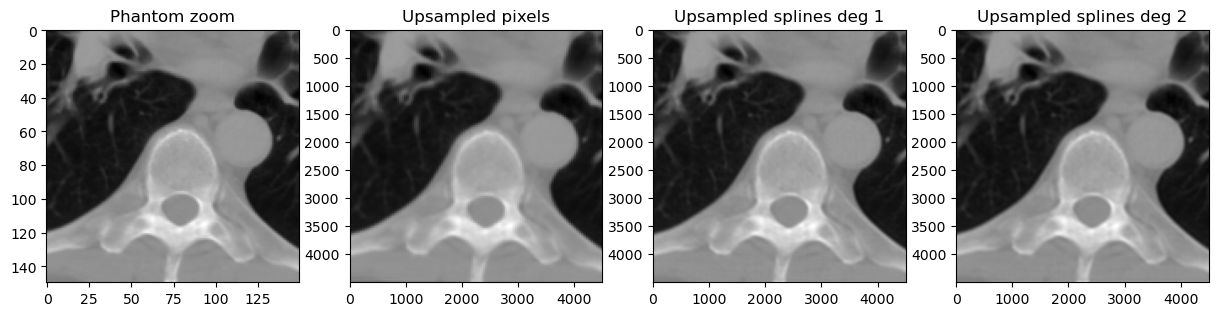

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(phantom.get()[150:300, 50:200], cmap='gray')
ax[0].set_title('Phantom zoom')
ax[1].imshow(full_im_pix[int(150*nn/3):int(300*nn/3), int(50*nn/3):int(200*nn/3)], cmap='gray')
ax[1].set_title('Upsampled pixels')
ax[2].imshow(full_im_splinedeg1[int(150*nn/3):int(300*nn/3), int(50*nn/3):int(200*nn/3)], cmap='gray')
ax[2].set_title('Upsampled splines deg 1')
ax[3].imshow(full_im_spline[int(150*nn/3):int(300*nn/3), int(50*nn/3):int(200*nn/3)], cmap='gray')
ax[3].set_title('Upsampled splines deg 2')

plt.show()

/home/haouchat/cryoem/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
/home/haouchat/cryoem/xrt_splines.py:210: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)


sample normal
norm diff splines :  189449.52280350658
norm diff pixels  :  68131.74367725982
Oversampled
norm diff splines :  462863.89235778403
norm diff pixels  :  378871.20303772314


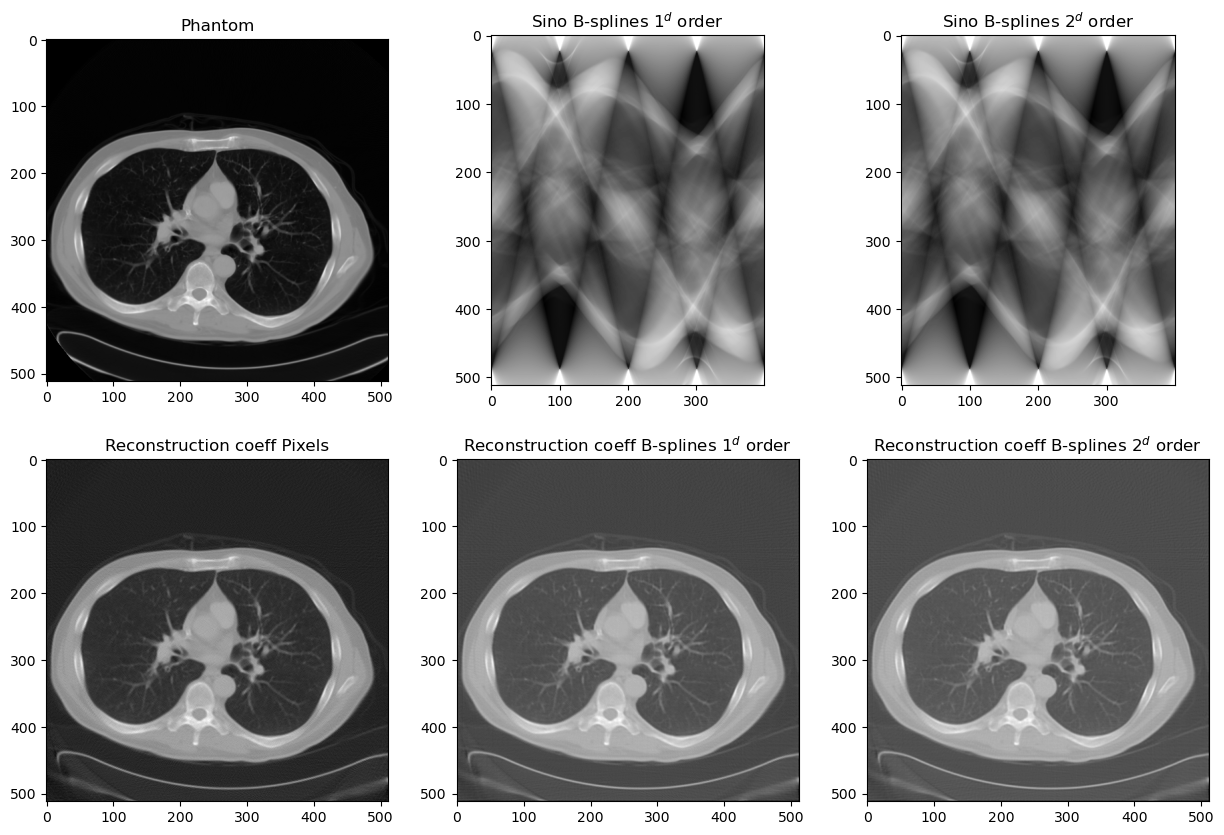

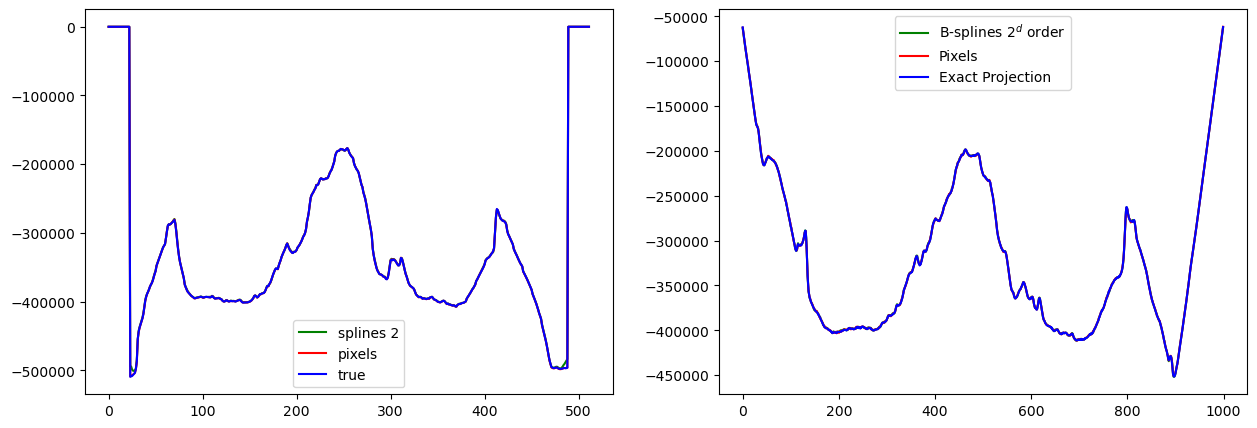

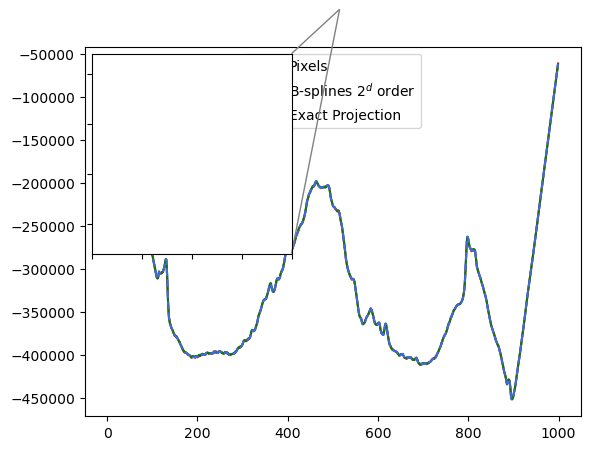

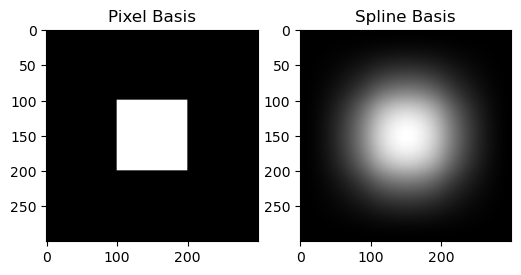

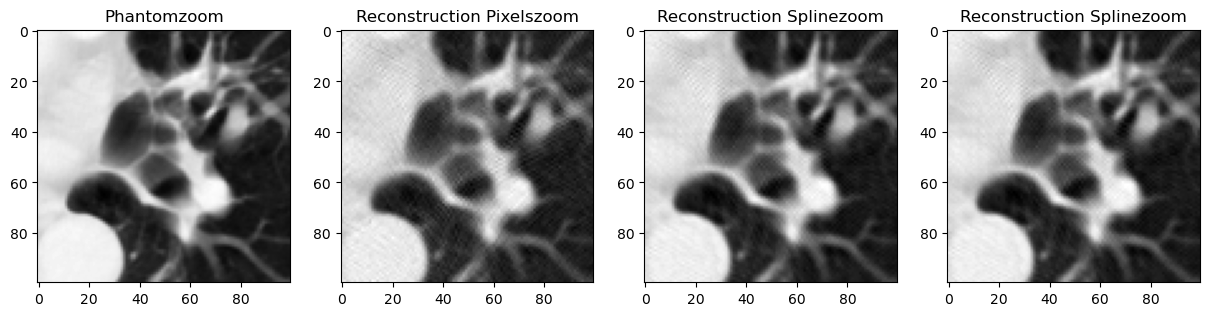

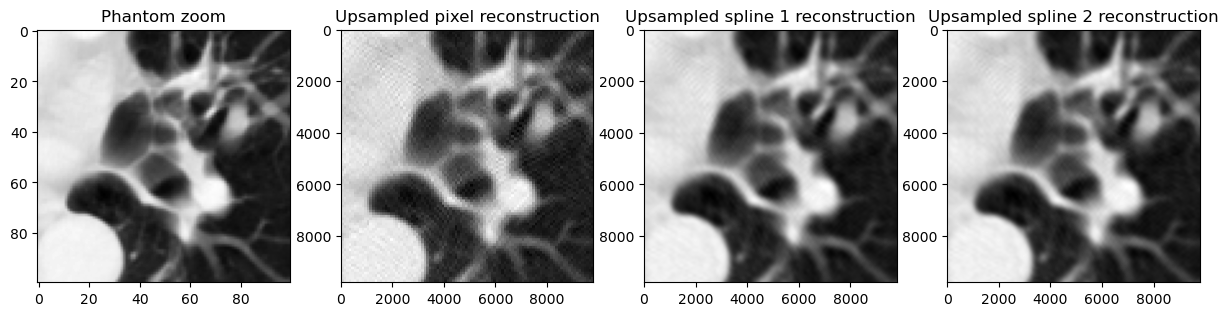

In [ ]:
pitch = 1.  # m/px [can differ per axis]
arg_shape = phantom.shape

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)


#N_angle  = 50
N_offset_true = 1000
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset_true, endpoint=True)

n_spec_true  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset_true, 2))  # (N_angle, N_offset_true, 2)
t_spec_true  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset_true, 1)  # (N_angle, N_offset_true, 2)
t_spec_true += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset_true,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec_true  = cp.array(t_spec_true)
n_spec_true  = cp.array(n_spec_true)

op_true = pxr.XRayTransform.init( #for reconstruction
    arg_shape=arg_shape,
    t_spec=t_spec_true.reshape(-1,2), 
    n_spec=n_spec_true.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

# benchmarking 
'''
bench_splines_1 = benchmark(op_splines_1.apply, (phantom.reshape(-1),), n_repeat=10)
print("splines : ", bench_splines_1)
bench_pixels    = benchmark(op_pixels.apply, (phantom.reshape(-1),), n_repeat=10)
print("pixels : ", bench_pixels)
breakpoint()
'''

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

stop_crit = pxst.MaxIter(30) #30 before

oversampling = N_offset
op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
)

#add noise
#y_data = np.array(y_data.get()) + 20*np.random.random(y_data.shape)
#y_data = cp.array(y_data)
recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#plt.figure('Phantom')
#plt.imshow(phantom, cmap='gray')
axes[0, 0].imshow(phantom.get(), cmap='gray')
axes[0, 0].set_title('Phantom')
#plt.figure('sino')
#plt.imshow(fwd_splines_1.reshape((N_angle, N_offset)).T, cmap='gray')
axes[0, 1].imshow(fwd_splines_1.T, cmap='gray')
axes[0, 1].set_title('Sino B-splines $1^d$ order')

axes[0, 2].imshow(fwd_splines_2.T, cmap='gray')
axes[0, 2].set_title('Sino B-splines $2^d$ order')

#plt.figure('recon pix')
#plt.imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].imshow(recon_pixels.get(), cmap='gray')
axes[1, 0].set_title('Reconstruction coeff Pixels')

#plt.figure('recon splines 1')
#plt.imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].imshow(recon_box_1.get(), cmap='gray')
axes[1, 1].set_title('Reconstruction coeff B-splines $1^d$ order')

#plt.figure('recon splines 2')
plt.imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].imshow(recon_box_2.get(), cmap='gray')
axes[1, 2].set_title('Reconstruction coeff B-splines $2^d$ order')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#plt.figure('fwd - recon')
fwd = op_splines_1.apply(recon_box_1.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[0], c='green', label='splines 2')
axes[0].plot(fwd_splines[0], c='green', label='splines 2')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[0], c='red', label='pixels')
axes[0].plot(fwd_pixels[0], c='red', label='pixels')
true_proj = y_data.get().reshape((N_angle, N_offset))
#plt.plot(true_proj[0], c='blue', label='true')
axes[0].plot(true_proj[0], c='blue', label='true')
print('sample normal')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)
axes[0].legend()


#N_angle  = 50
N_offset = 1000 
pitch = 1.

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT( #for reconstruction
    deg=1,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_splines_2 = xrt_splines.RayXRT( #for reconstruction
    deg=2,
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)
op_pixels = pxr.XRayTransform.init( #for reconstruction
    arg_shape=(oversampling, oversampling),
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=(phantom.shape[0]/oversampling,phantom.shape[0]/oversampling)
)

#plt.figure('fwd - recon (many offsets)')
fwd = op_splines_2.apply(recon_box_2.reshape(-1)).get()
fwd_splines = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
axes[1].plot(fwd_splines[9], c='green', label='B-splines $2^d$ order')
fwd = op_pixels.apply(recon_pixels.reshape(-1)).get()
fwd_pixels = fwd.reshape((N_angle, N_offset))
#plt.plot(fwd_pixels[9], c='red', label='Pixels')
axes[1].plot(fwd_pixels[9], c='red', label='Pixels')
true_proj = op_true.apply(phantom.reshape(-1)).get()
true_proj = true_proj.reshape((N_angle, N_offset_true))
#plt.plot(true_proj[9], c='blue', label='Exact Projection')
axes[1].plot(true_proj[9], c='blue', label='Exact Projection')
#plt.legend()
axes[1].legend()

fig, ax = plt.subplots()
axins = inset_axes(ax, 2,2 , loc=2)

ax.plot(fwd_pixels[9], label='Pixels', c='red')
axins.plot(fwd_pixels[9], label='Pixels', c='red')

ax.plot(fwd_splines[9], label='B-splines $2^d$ order', c='green')
axins.plot(fwd_splines[9], label='B-splines $2^d$ order', c='green')

ax.plot(true_proj[9], label='Exact Projection', c='royalblue', linestyle = '--')
axins.plot(true_proj[9], label='Exact Projection', c='royalblue', linestyle = '--')


x1, x2, y1, y2 = 505-10, 505+10, 1332-10, 1332+10 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
ax.legend()

print('Oversampled')
norm1 = np.linalg.norm(true_proj - fwd_splines)
print('norm diff splines : ', norm1)
norm2 = np.linalg.norm(true_proj - fwd_pixels)
print('norm diff pixels  : ', norm2)

# Upsampling to approach continuum

mini_im = np.zeros((300,300))
mini_im_pix = mini_im
mini_im_spline = mini_im

rec_pix = recon_pixels.get()
rec_spline1 = recon_box_1.get()
rec_spline2 = recon_box_2.get()


mini_im_pix[100:200, 100:200] = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
#plt.figure('pix upsampling')
#plt.imshow(mini_im_pix, cmap='gray')
ax[0].imshow(mini_im_pix, cmap='gray')
ax[0].set_title('Pixel Basis')

mini_im_spline1 = spconv(mini_im_pix, mini_im_pix[100:200, 100:200], mode='same')/100**2
mini_im_spline2 = spconv(mini_im_spline1, mini_im_pix[100:200, 100:200], mode='same')/100**2

#plt.figure()
#plt.imshow(mini_im_spline)
ax[1].imshow(mini_im_spline2, cmap='gray')
ax[1].set_title('Spline Basis')

fig, ax = plt.subplots(1, 4, figsize=(15, 5)) #plot zoomed in reconstructions : phantom, pixel, spline
ax[0].imshow(phantom.get()[250:350, 250:350], cmap='gray')
recpixzoom = rec_pix[250:350, 250:350]
recsplinezoom1 = rec_spline1[250:350, 250:350]
recsplinezoom2 = rec_spline1[250:350, 250:350]
ax[0].set_title('Phantomzoom')
ax[1].imshow(recpixzoom, cmap='gray')
ax[1].set_title('Reconstruction Pixelszoom')
ax[2].imshow(recsplinezoom1, cmap='gray')
ax[2].set_title('Reconstruction Splinezoom')
ax[3].imshow(recsplinezoom2, cmap='gray')
ax[3].set_title('Reconstruction Splinezoom')

Nup = recpixzoom.shape[0]*100 + 200    
full_im_pix = np.zeros((Nup, Nup))
for i in range(recpixzoom.shape[0]):
    for j in range(recpixzoom.shape[1]):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_pix[i_min : i_max, j_min:j_max] += mini_im_pix * recpixzoom[i,j]

full_im_spline1 = np.zeros((Nup, Nup))
for i in range(recpixzoom.shape[0]):
    for j in range(recpixzoom.shape[1]):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_spline1[i_min : i_max, j_min:j_max] += mini_im_spline2 * recsplinezoom1[i,j]

full_im_spline2 = np.zeros((Nup, Nup))
for i in range(recpixzoom.shape[0]):
    for j in range(recpixzoom.shape[1]):
        i_min, i_max, j_min, j_max = 100*i, 100*i+300, 100*j, 100*j+300
        full_im_spline2[i_min : i_max, j_min:j_max] += mini_im_spline2 * recsplinezoom2[i,j]

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
#plt.figure('upsampled pix')
#plt.imshow(full_im_pix[100:-100, 100:-100], cmap='gray')
ax[0].imshow(phantom.get()[250:350, 250:350], cmap='gray')
ax[0].set_title('Phantom zoom')
ax[1].imshow(full_im_pix[200:-200, 200:-200], cmap='gray')
ax[1].set_title('Upsampled pixel reconstruction')
#plt.figure('upsampled spline')
#plt.imshow(full_im_spline[100:-100, 100:-100], cmap='gray')
ax[2].imshow(full_im_spline1[200:-200, 200:-200], cmap='gray')
ax[2].set_title('Upsampled spline 1 reconstruction')
ax[3].imshow(full_im_spline2[200:-200, 200:-200], cmap='gray')
ax[3].set_title('Upsampled spline 2 reconstruction')

#plt.figure('diff pix')
#plt.imshow(full_im_pix[100:-100, 100:-100] - phantom.get(), cmap='gray')
#plt.figure('diff splines')
#plt.imshow(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get(), cmap='gray')

'''
print(np.linalg.norm(full_im_pix[100:-100, 100:-100] - phantom.get()))
print(np.linalg.norm(full_im_spline[100:-100, 100:-100]/np.max(full_im_spline[100:-100, 100:-100]) - phantom.get()))
'''

plt.show()

One non zero coefficient


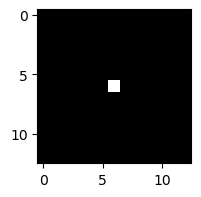

In [ ]:
N_side = 13 # N_px = N_side**2
pitch = 1.  # m/px [can differ per axis]
phantom = np.zeros((N_side, N_side))

phantom[ N_side//2, N_side//2 ] = 1

arg_shape = phantom.shape

plt.figure(figsize=(2,2))
plt.imshow(phantom, cmap='gray')

N_angle  = 1 
N_offset = 5000 

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
phantom = cp.array(phantom)
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

op_splines_1 = xrt_splines.RayXRT(
    deg=1,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_splines_2 = xrt_splines.RayXRT(
    deg=2,
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
op_pixels = pxr.XRayTransform.init(
    arg_shape=arg_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)
print('One non zero coefficient')

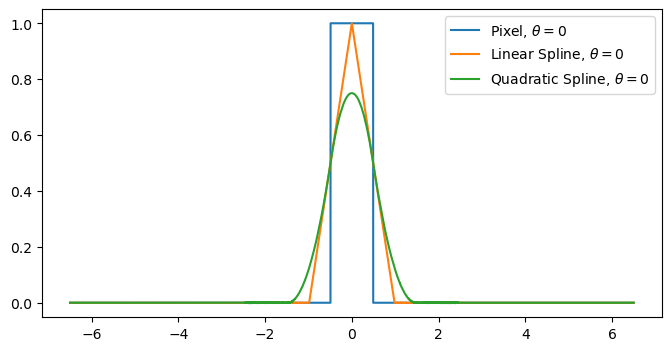

In [ ]:
fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

y_data = fwd_pixels

# benchmarking 
'''
bench_splines_1 = benchmark(op_splines_1.apply, (phantom.reshape(-1),), n_repeat=10)
print("splines : ", bench_splines_1)
bench_pixels    = benchmark(op_pixels.apply, (phantom.reshape(-1),), n_repeat=10)
print("pixels : ", bench_pixels)
breakpoint()
'''

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

plt.figure('X-ray spline Projection', figsize=(8,4))
for k in range(len(angles)):
    num = k
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num])), fwd_pixels[num], label=r'Pixel, $\theta=0$')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], label=r'Linear Spline, $\theta=0$')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], label=r'Quadratic Spline, $\theta=0$')

    plt.legend()


"plt.figure('X-ray Box-splines')\n\nfor k in range(len(angles)):\n    num = k\n    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num])), fwd_pixels[num], label=r'Pixel, $\theta=0$')\n    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], label=r'Linear Spline, $\theta=0$', c='blue')\n    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], label=r'Quadratic Spline, $\theta=0$', c='red')\n\nplt.show()"

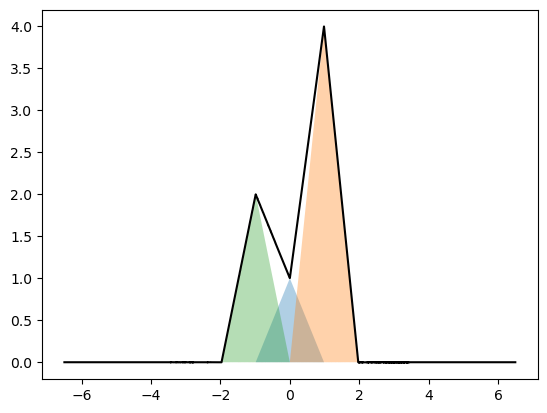

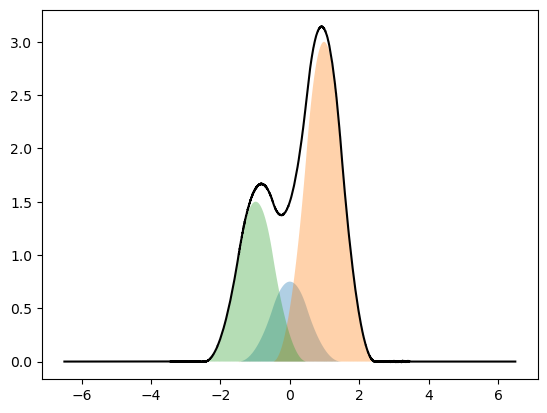

In [ ]:
plt.figure('Spline construction : CPWL')
for k in range(len(angles)):
    num = k
    
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 0
    phantom[N_side//2,N_side//2+1] = 4
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    
    phantom[N_side//2,N_side//2+1] = 0
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 1
    phantom[N_side//2,N_side//2+1] = 4
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
    fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], color='k')

plt.figure('Spline construction : CPWQ')
for k in range(len(angles)):
    num = k
    
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 0
    phantom[N_side//2,N_side//2-1] = 0
    phantom[N_side//2,N_side//2+1] = 4
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    
    phantom[N_side//2,N_side//2+1] = 0
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    #plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num])
    plt.fill(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], alpha=0.35)
    
    phantom[N_side//2,N_side//2] = 1
    phantom[N_side//2,N_side//2+1] = 4
    phantom[N_side//2,N_side//2-1] = 2
    fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
    fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], color='k')
    
#phantom[N_side//2,N_side//2] = 0 test ici pour git
phantom[N_side//2,N_side//2+1] = 0
phantom[N_side//2,N_side//2-1] = 0
fwd_splines_1 = op_splines_1.apply(phantom.reshape(-1))
fwd_splines_2 = op_splines_2.apply(phantom.reshape(-1))
fwd_pixels = op_pixels.apply(phantom.reshape(-1))

fwd_splines_1 = fwd_splines_1.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_splines_2 = fwd_splines_2.reshape((N_angle, N_offset)).get() #remove .get() for CPU
fwd_pixels = fwd_pixels.reshape((N_angle, N_offset)).get() #remove .get() for CPU

'''plt.figure('X-ray Box-splines')

for k in range(len(angles)):
    num = k
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_pixels[num])), fwd_pixels[num], label=r'Pixel, $\theta=0$')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_1[num])), fwd_splines_1[num], label=r'Linear Spline, $\theta=0$', c='blue')
    plt.plot(np.linspace(-N_side/2, N_side/2, num= len(fwd_splines_2[num])), fwd_splines_2[num], label=r'Quadratic Spline, $\theta=0$', c='red')

plt.show()'''